<img src="./logo_UNSAM.jpg" align= "right" width= "150" /> -->
## APS
## Trabajo práctico semanal 3: *Modelizando un ADC*
### Violeta Manterola

En esta tarea semanal retomamos la consigna de la tarea anterior, donde simulamos el bloque de cuantización de un ADC de B bits en un rango de  ±VF
 Volts. Ahora vamos a completar la simulación del ADC incluyendo la capacidad de muestrear a fs Hertz.

Para ello se simulará el comportamiento del dispositivo al digitalizar una senoidal contaminada con un nivel predeterminado de ruido. Comenzaremos describiendo los parámetros a ajustar de la senoidal:

-  frecuencia $f_{0}$ arbitraria, por ejemplo $f_{0}=\frac{f_{s}}{N}=Δf$
-  energía normalizada, es decir energía (o varianza) unitaria
Con respecto a los parámetros de la secuencia de ruido, diremos que:
-  será de carácter aditivo, es decir la señal que entra al ADC será $s_{R}=s+n$.
Siendo n la secuencia que simula la interferencia, y s la senoidal descrita anteriormente.
-  La potencia del ruido será $P_{n}=K_{n}*P_{q}$ siendo el factor $K_{n}$ una escala para la potencia del ruido de cuantización $P_{q}$=$q^12$
finalmente, n será incorrelado y Gaussiano.
El ADC que deseamos simular trabajará a una frecuencia de muestreo $f_s = 1000$ Hz y tendrá un rango analógico de $\pm V_F = 2$ Volts.

a) $B = 4$ bits y $K_n = 1$

b) $B = {4,\ 8,\ 16}$ y $K_n =  {1/10,\ 1,\ 10}$

-  Encontrar la relación entre la cantidad de B bits del ADC y el SNR de la señal digitalizada. (Ver Holton. DSP Principles and App. 6.7 ADC Quantization pag. 387 )     
    **Bonus:** Simular el efecto del aliasing junto con el muestreo.

--------------------------------------------------------------------------------------------------------------------------------------------------------

Para simular el comportamiento del dispositivo al digitalizar una senoidal contaminada con un nivel predeterminado de ruido, se realizaron tres gráficos para analizar los efectos de cuantización:  
-  **Primer gráfico:** se compara la señal que ingresa al ADC con la señal digitalizacda resultante, donde se espera que a medida que aumenten los bits mayor resolución tendrá el ADC y mas similares se verán las señales. 
-  **Segundo gráfico:** se visualizan los espectros, haciendo incapié en los pisos de ruido, analógico y digital (cuantización). En este caso, mientras mayor sea kn.. a su vez, al aumentar el número de bits se espera que el piso de ruido de cuantización este por debajo del analógico, indicando un mejor desemepeño del ADC. 
-  **Tercer gráfico:** tenemos un histograma que representa el error de cuantización y la frecuencia relativa, donde el resultado esperado es una distribución uniforme de los datos entre (-q/2, q/2) y con un valor de frecuencia relativa máxima de N/(cantidad de bits) ==> 100

In [42]:
import numpy as np
import matplotlib.pyplot as plt

def my_funcion_sen(vmax=1, dc=0, ff=1, ph=0, nn=1000, fs=1000):
    ts = 1/fs
    t_simulacion = nn * ts
    tt = np.arange(start=0, stop=t_simulacion, step=ts)
    xx = dc + vmax * np.sin(2 * np.pi * ff * tt + ph)
    return tt, xx
def simular_adc(B=4, kn=1.0, Vf=2.0, N=1000, fs=1000,aliasing=False): #armo una función para poder así llamarla y variar el numero de bits y kn.
    #paso de cuantización
    q = Vf / 2**(B - 1)
    df = fs / N
    fa = 0.75*fs if aliasing else df #para incluir luego el caso con aliasing!!
    #señal sinusoidal sin ruido 
    tt, xx = my_funcion_sen(vmax=1, dc=0, ff=fa, ph=0, nn=N, fs=fs)
    xn = xx / np.std(xx)  # normalización para una varianza = 1

    #ruido analógico
    pot_ruido = (q**(2) / 12) * kn
    nn = np.random.normal(0, np.sqrt(pot_ruido), size=N) #genera señal ruido analógico gaussiano.
    # señal con ruido (aditivo)
    sr = xn + nn

    #cuantización de la señal 
    srq = np.round(sr / q) * q
    #ruido
    nq = srq - sr

    #FFTs
    ft_SR = 1/N * np.fft.fft(sr)
    ft_Srq = 1/N * np.fft.fft(srq)
    ft_xn = 1/N * np.fft.fft(xn)
    ft_Nq = 1/N * np.fft.fft(nq)
    ft_Nn = 1/N * np.fft.fft(nn)

    #frecuencias
    ff = np.linspace(0, (N-1)*df, N)
    bfrec = ff <= fs/2

    #potencias promedio
    nNn_mean = np.mean(np.abs(ft_Nn)**2)
    Nnq_mean = np.mean(np.abs(ft_Nq)**2)

    # Gráfico temporal
    # separo para el ultima caso, el de aliasing, donde grafico x separado la señal analógica pura para apreciar el efecto
    if aliasing:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(tt, xn, color='orange', label='$s$ (analógica)')
        plt.xlim(0, 0.4)
        plt.title('Señal analógica original (sin ruido, sin cuantizar)')
        plt.xlabel('Tiempo [s]')
        plt.ylabel('Amplitud [V]')
        plt.grid(True)
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(tt, srq, linestyle='-', color='blue',alpha=0.7,label='$s_Q$ (ADC out)')
        plt.plot(tt, sr, 'go:', markersize=2, label='$s_R = s + n$ (ADC in)')
        plt.title(f'Señal ADC - {B} bits, ±$V_R$={Vf} V, q={q:.3f} V')
        plt.xlim(0, 0.4)
        plt.xlabel('Tiempo [s]')
        plt.ylabel('Amplitud [V]')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()    
    elif (B == 8 and kn == 1) or (B == 16 and kn == 10): #casos especificos sin aliasing, donde hagp un gráfico aparte con zoom para apreciar...
         #... la difenrecia entre la señal de entrada vs la señal cuantizada.
            plt.figure(figsize=(12, 4))
            
            plt.subplot(1, 2, 1)
            plt.plot(tt, srq, linestyle='-', color='blue',alpha=0.7,label='$s_Q$ (ADC out)')
            plt.plot(tt, sr, 'go:', markersize=2, alpha=0.7,label='$s_R = s + n$ (ADC in)')
            plt.plot(tt, xn, linestyle=':', color='orange',alpha=0.7, label='$s$ (analógica)')
            plt.title(f'Señal ADC - {B} bits, ±$V_R$={Vf} V, q={q:.3f} V')
            plt.xlabel('Tiempo [s]')
            plt.ylabel('Amplitud [V]')
            plt.legend()
            plt.grid(True)
    
            plt.subplot(1, 2, 2)
            plt.plot(tt, srq, linestyle='-', color='blue', label='$s_Q$ (ADC out)')
            plt.plot(tt, sr, 'go:', markersize=2, label='$s_R = s + n$ (ADC in)')
            plt.plot(tt, xn, linestyle=':', color='orange', label='$s$ (analógica)')
            plt.xlim(0, 0.06)
            plt.ylim(0, 0.6)
            plt.title('Zoom (0 - 0.06 s)')
            plt.xlabel('Tiempo [s]')
            plt.ylabel('Amplitud [V]')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
    else:
            #resto de los casos generales.
            plt.figure(figsize=(10, 6))
            #Señal cuantizada s_Q, sale cuantizada del ADC (out)
            plt.plot(tt, srq, linestyle='-', color='blue',alpha=0.7,label='$s_Q$ (ADC out)')
            #Señal con ruido s_R, es la que entra al ADC (in)
            plt.plot(tt, sr, 'go:',alpha=0.7, markersize=2, label='$s_R = s + n$ (ADC in)')
            #Señal analógica s
            plt.plot(tt, xn, linestyle=':', color='orange',alpha=0.7, label='$s$ (analógica)')
            plt.title(f'Señal ADC - {B} bits, ±$V_R$={Vf} V, q={q:.3f} V')
            plt.xlabel('Tiempo [s]')
            plt.ylabel('Amplitud [V]')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        
    # Gráfico espectral
    #hago esto para limitar el eje y para q se aprecie mejor en los gráficos la difrencia entre los pisos de ruido. 
    piso_analog_db = 10 * np.log10(2 * nNn_mean)
    piso_digital_db = 10 * np.log10(2 * Nnq_mean)
    piso_min = min(piso_analog_db, piso_digital_db) # q busque cual esta más abajo y luego hacer un margen para cortar el eje y
    #margen (-50 dB más abajo del piso más bajo)
    margen_db = 50
    ymin = piso_min - margen_db
    plt.figure(figsize=(15, 8))
    plt.ylim(ymin, 1)
    plt.plot( ff[bfrec], 10* np.log10(2*np.abs(ft_Srq[bfrec])**2), lw=2, color='magenta',label='$ s_Q = Q_{B,V_F}\{s_R\}$ (ADC out)' )
    plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_xn[bfrec])**2), ':b', label='$s$ (analógica)')
    plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_SR[bfrec])**2), ':g', label='$s_R = s + n$ (ADC in)')
    plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Nn[bfrec])**2), ':r')
    plt.plot(ff[bfrec], 10 * np.log10(2 * np.abs(ft_Nq[bfrec])**2), ':c')
    plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([nNn_mean, nNn_mean]) ), '--r', label= '$ \overline{n} = $' + '{:3.1f} dB (piso analog.)'.format(10* np.log10(2* nNn_mean)) )
    plt.plot( np.array([ ff[bfrec][0], ff[bfrec][-1] ]), 10* np.log10(2* np.array([Nnq_mean, Nnq_mean]) ), '--c', label='$ \overline{n_Q} = $' + '{:3.1f} dB (piso digital)'.format(10* np.log10(2* Nnq_mean)) )
    plt.title('Espectro de señales y ruidos')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Densidad de Potencia [dB]')
    plt.legend(fontsize=14, loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Histograma del ruido de cuantización
    # con esto puedo ver cuantas veces el rudio de cuantixaci{on cae en ciertos rangos. 
    plt.figure(figsize=(6, 4))
    #plt.figure(3)
    bins = 10
    plt.hist(nq.flatten(), bins=bins)
    plt.plot( np.array([-q/2, -q/2, q/2, q/2]), np.array([0, N/bins, N/bins, 0]), '--r' ) #genera línea punteada q delimita el rango esperado del rudio de cuantización.
    plt.title( 'Ruido de cuantización para {:d} bits - $\pm V_R= $ {:3.1f} V - q = {:3.3f} V'.format(B, Vf, q))
    plt.xlabel('Error de cuantización [V]')
    plt.ylabel('Frecuencia relativa')
    plt.show()

## *Representación y análisis de los resultados.* 

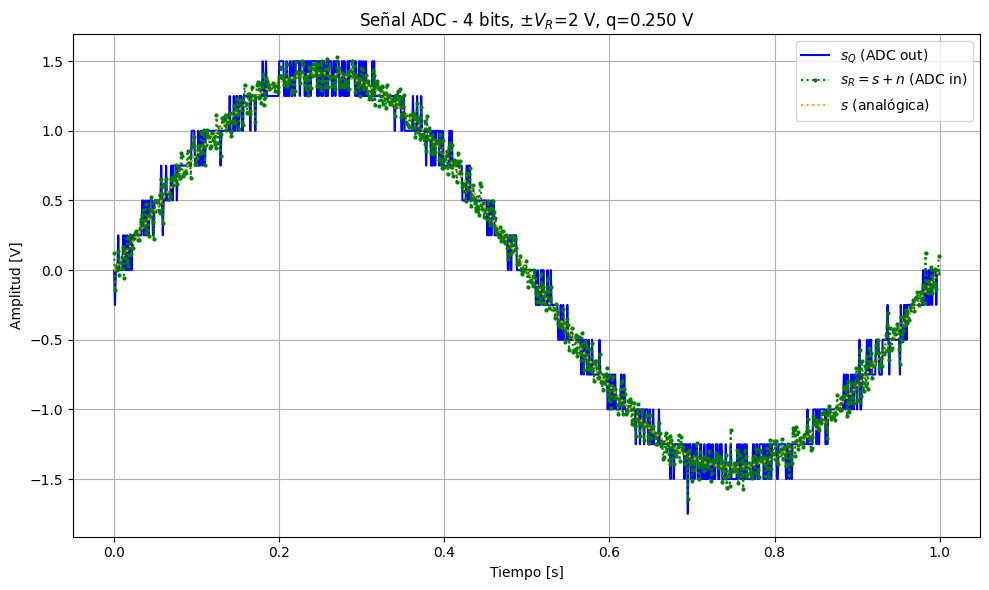

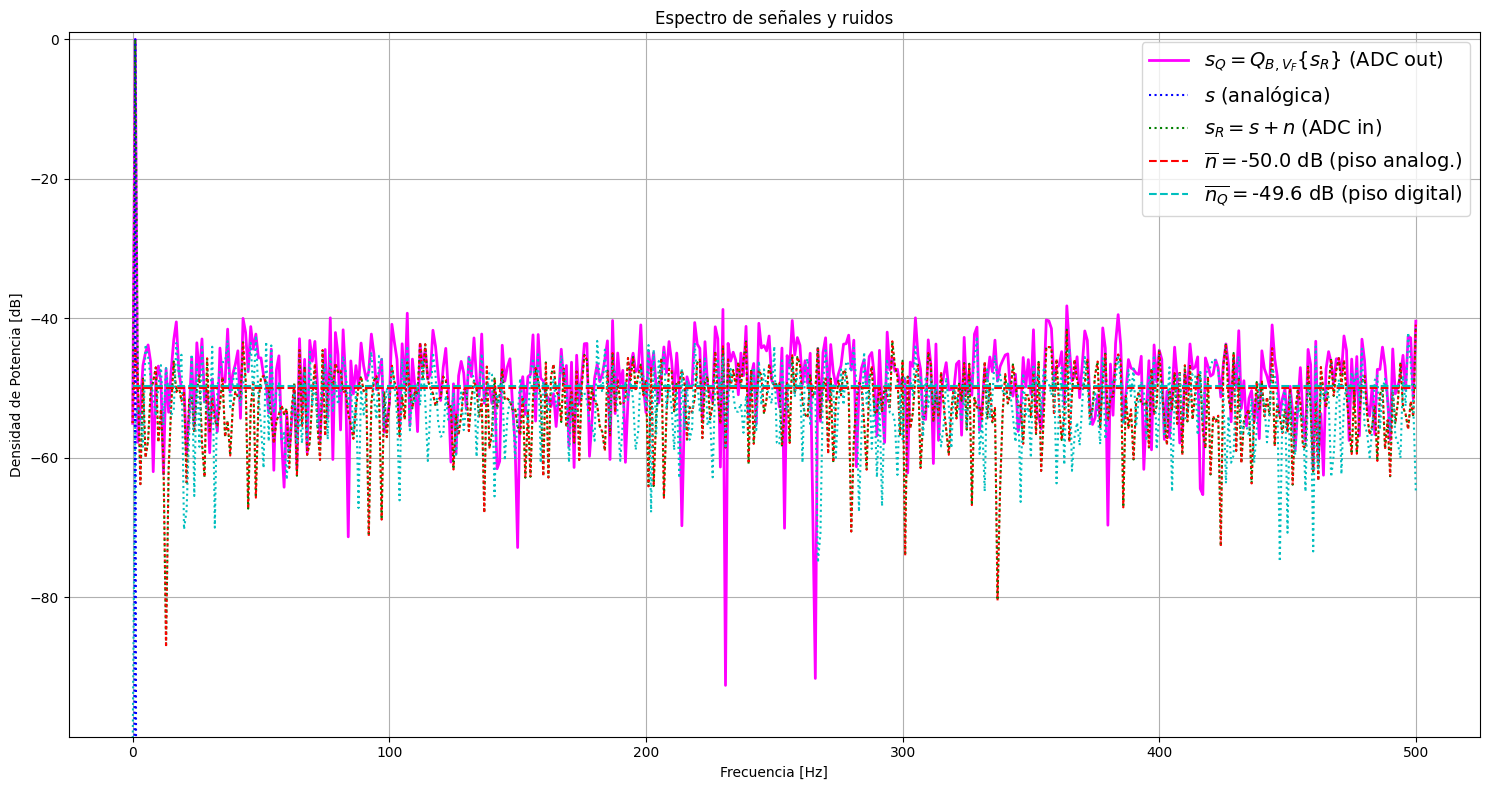

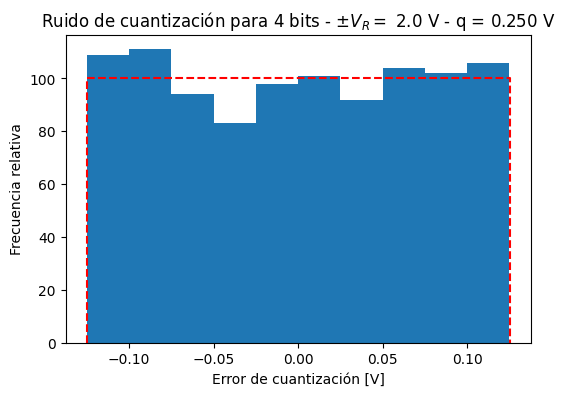

In [33]:
# a) Primer caso B=4 y Kn=1
simular_adc(B=4, kn=1.0, Vf=2, fs=1000, N=1000,aliasing=False)

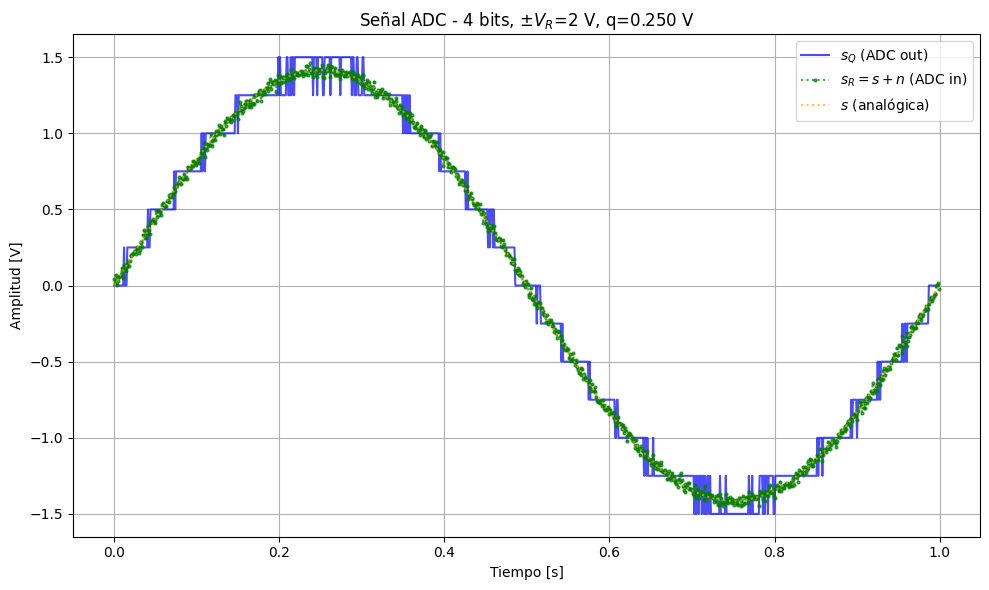

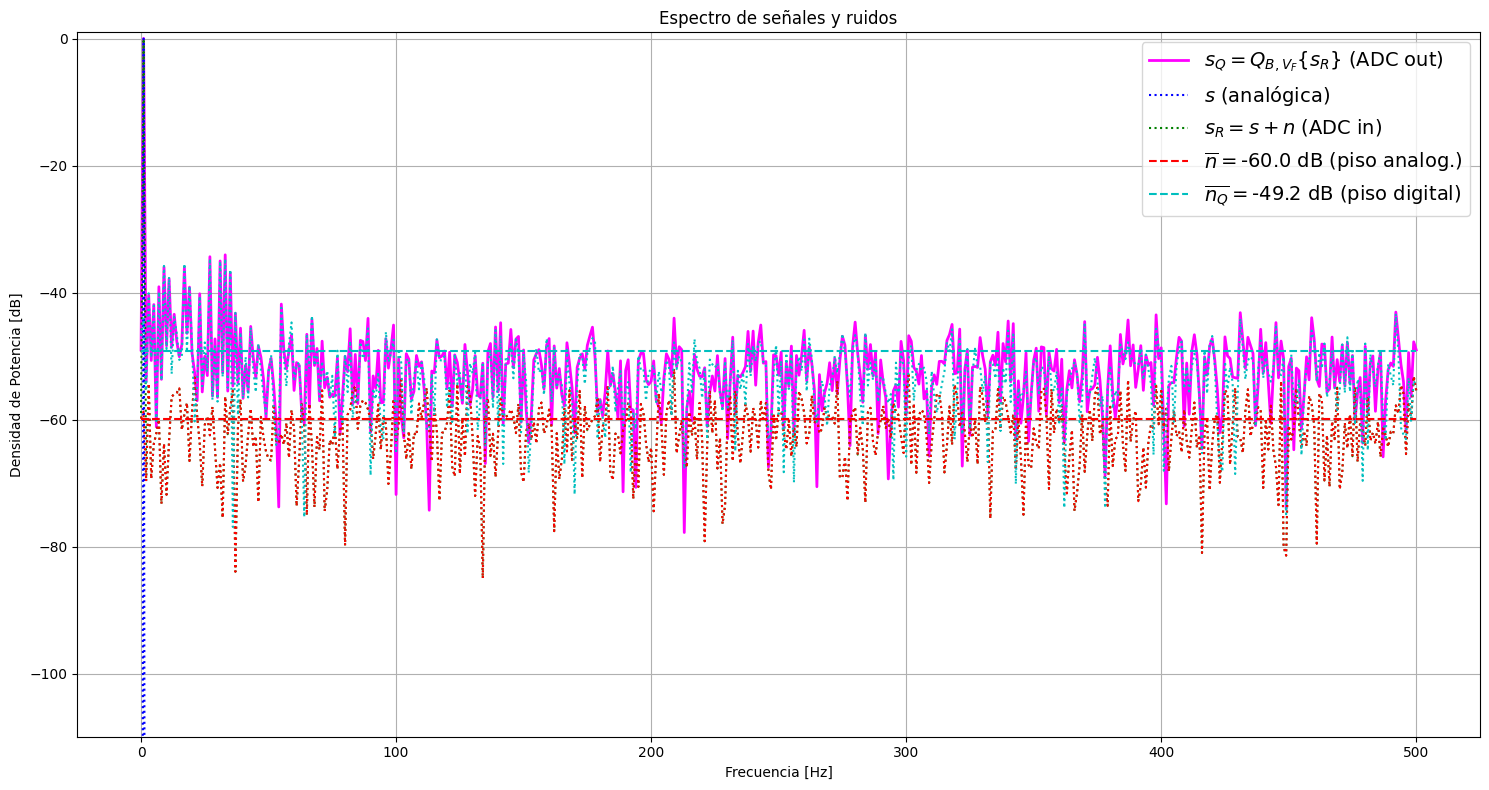

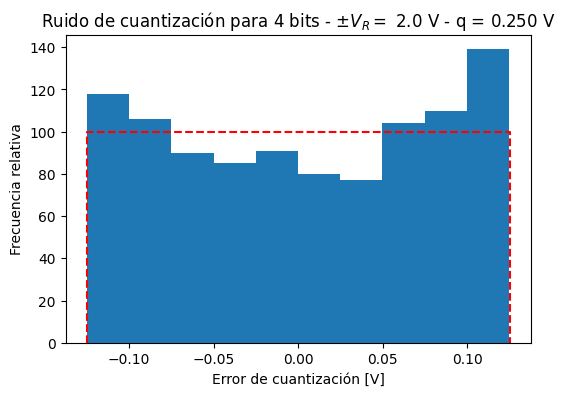

In [40]:
# b)
#Primer caso B=4 y Kn=1/10
simular_adc(B=4, kn=1/10., Vf=2, fs=1000, N=1000,aliasing=False)

-  **Comparando** estas dos primeras situaciones(kn=1 y kn=1/10) puede verse como la mayor discrepancia radica en que con $K_{n}=1/10$, es posible notar la diferencia que existe entre los pisos de ruido. Al ser  $K_{n}<1$ el piso de ruido de cuantización predomina por sobre el analógico, con una diferencia de 10dB aproximadamente, reduciendo la calidad de la señal.
-  En cuanto al gráfico de ruido de cuantización, los resultados obtenidos en la primera experiencia son mas cercanos a los esperados. 

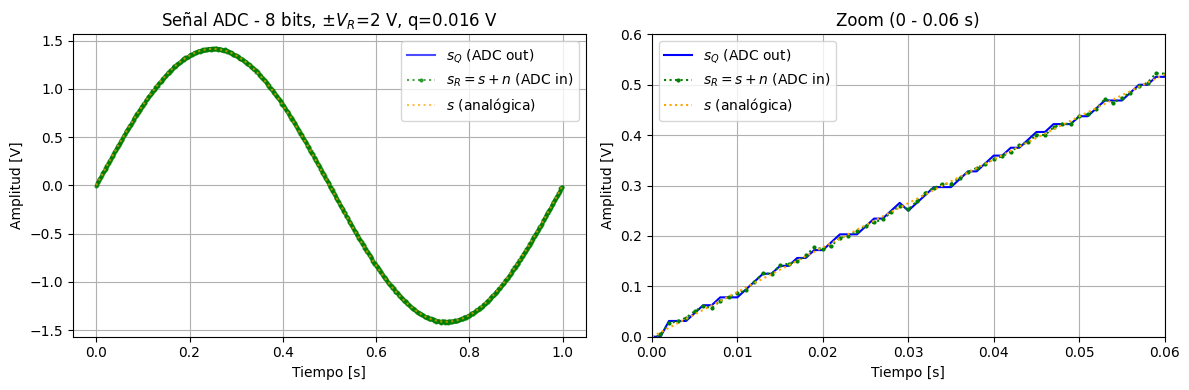

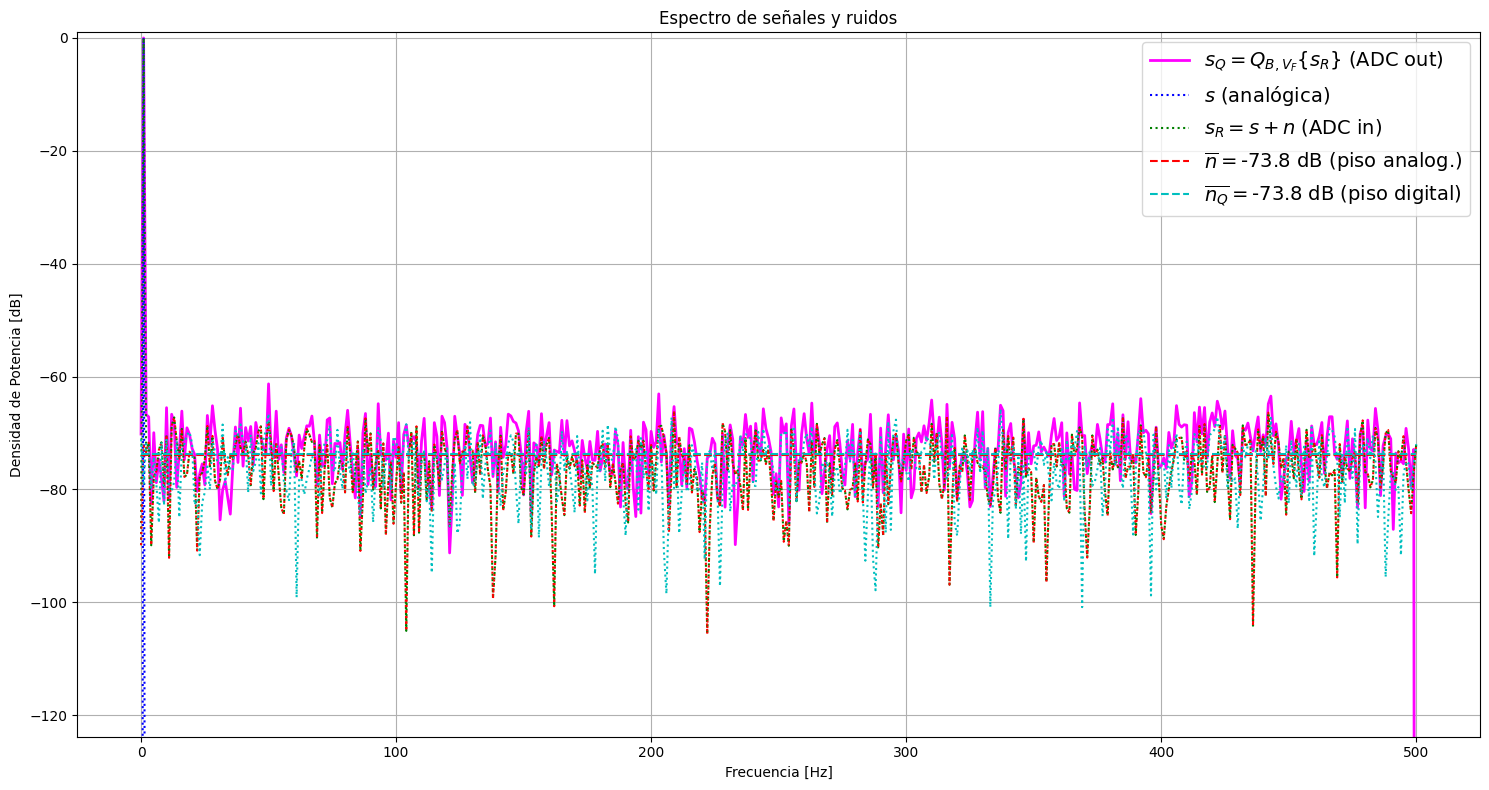

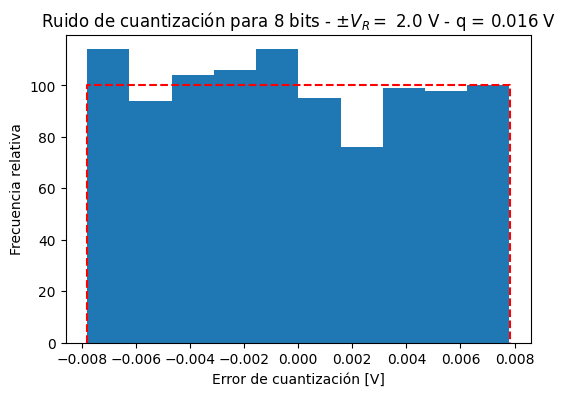

In [43]:
#Primer caso B=8 y Kn=1
simular_adc(B=8, kn=1., Vf=2, fs=1000, N=1000)

-  Por otro lado, aumentamos la cantidad de bits a 8, y se volvió a un $K_{n}=1$. Al un número de bits mas elevado implica un paso de cuantización más pequeño, haciendo que la señal cuantizada que sale del ADC sea cada vez más similar la que ingresa, disminuyendo así el error de cuantización significativamente (en comparación con el caso previo de 4bits).
-  Además, con este incremento de la cantidad de bits, puede observarse como en el gráfico 1 las señales empiezan a verse más similares; ya que se esta aumentando la resolución del ADC. 

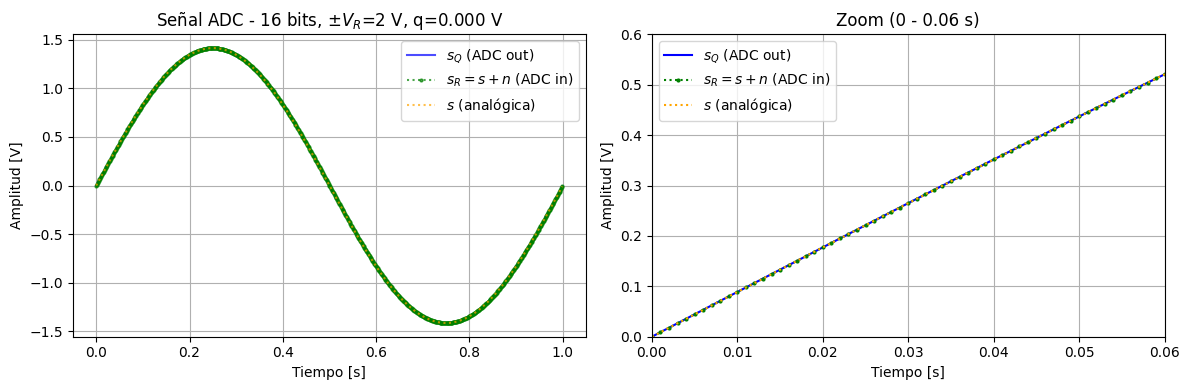

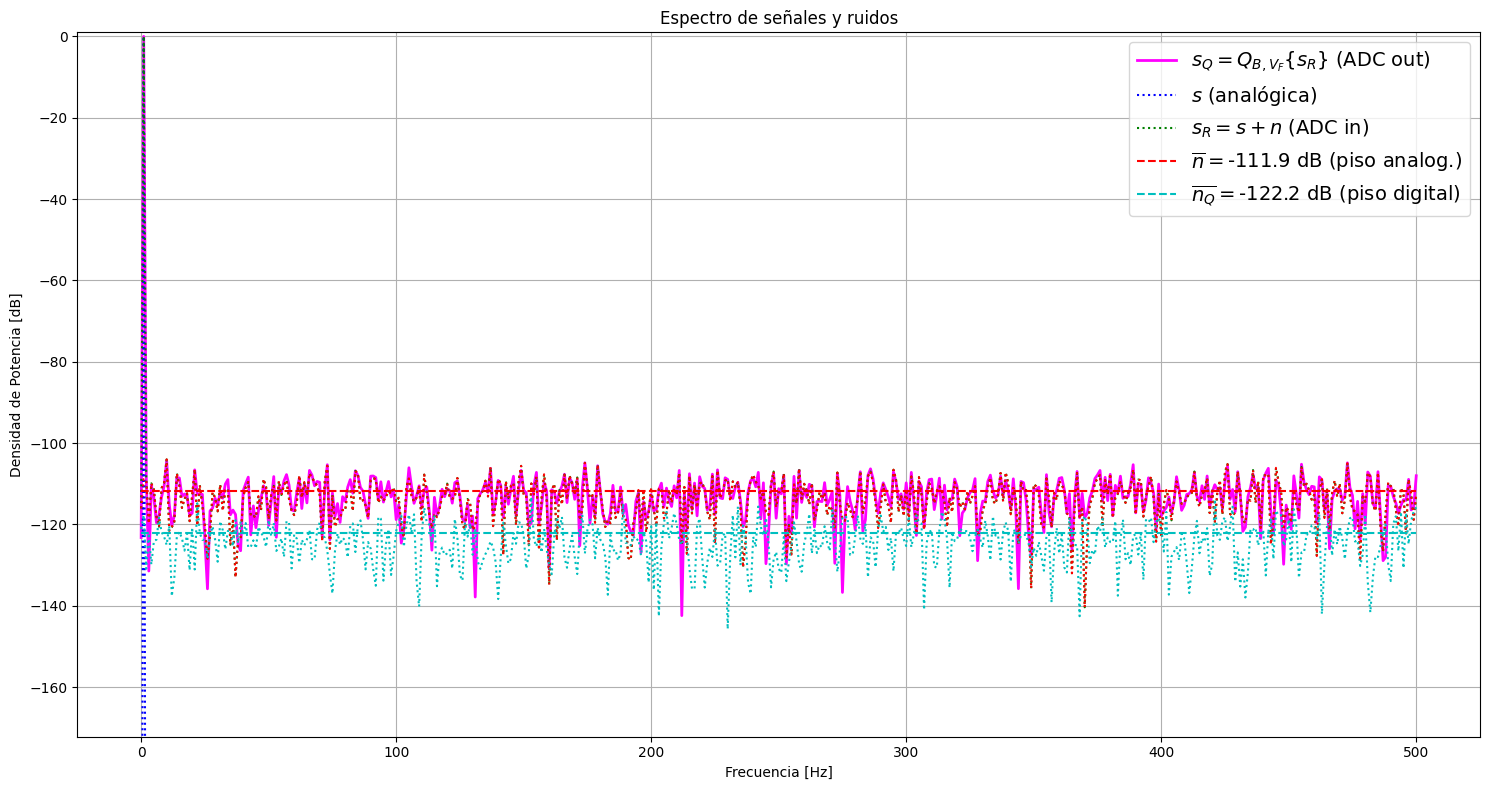

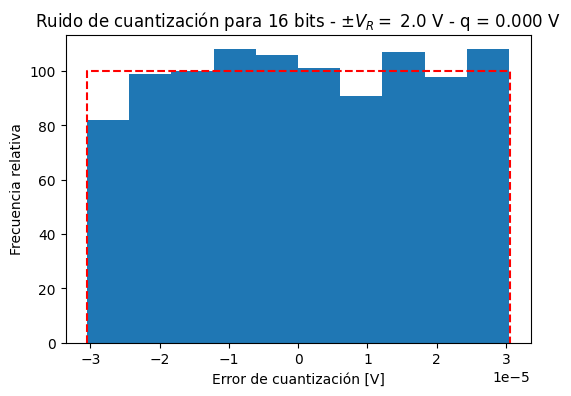

In [44]:
#caso B=16 y Kn=10
simular_adc(B=16, kn=10., Vf=2, fs=1000, N=1000, aliasing=False)

-  En el caso de B=16 y Kn=10, al ser una valor tan elevado e bits, el valor resulta muy pequeño, tendiendo a 0.
$$
q = \frac{V_f}{2^{B-1}} = \frac{2}{2^{15}} = \frac{2}{32768} \approx 6.10 \times 10^{-5}\, \text{V}
$$
Es decir, estamos ante un caso ideal de un ADC con una muy buena resolución, esto puede observarse en el histograma ya que se obtiene un respeusta bastante uniforme, dentro de los rangos esperados. Apreciar la escala en la que se encuentra el eje x, del orden de 1e-5, indicando un error de cuantización muy bajo.
Luego, esto inifiere en el potencial de ruido, lo que hace que mi señal final con el ruido añadido siga siendo practicamente igual a la ideal, es por esto que parece no existir difrencias entre las señales representadas en la figura 1. Esto refuerza  que estoy ante un ADC con muy buena resolución, es por esto que en el gráfico espectral, puede verse como el rudio analógico es alrededor de 10dB mayor al de cuantización.

-  La relación entre el número de bits (B) y SNR (**signal-to-noise-ratio**), expresado en decibeles, de la señal digitalizada:
Teneiendo definida la potencia de ruido de cuanización y la potencia de la señal como:
$$
P_q = \frac{q^{2}}{12}
$$
$$
P_s = \frac{V_f^{2}}{2}
$$
$$
SNR ={10}{log_{10}}\frac{P_{señal}}{P_q} = 6.02*B +{10}{log_{10}}(1.5)
$$
Esta expresión demuestra entonces que el SNR depende de la resolución del conversor (Bits). Cada bit adicional de resolución aumenta el valor del SNR en aproximadamente 6dB; lo que quiere decir que la señal digitalizada se parece más a la original. Esto confirma lo que fue analizado en base a los resultados obtenidos de los gráficos, un mayor número de bits implica una mejor resolución del ADC. 


### *Bonus*

Por úiltimo, si se quiere analizar el efecto de aliasing junto con el de muestro, puede hacerse en un caso e nel que la frecuencia sea superior a Nyquist, fs/2. En este caso, como fue analizado en trabajos previos, por encima de la freceucnia de nyquist donde se produce un "solapamiento" de las frecuencias, lo que hace que altas freuencias se confundan con bajas. Entonces, probar con una frecuencia > a fs/2 es clave para provocar un aliassing. 

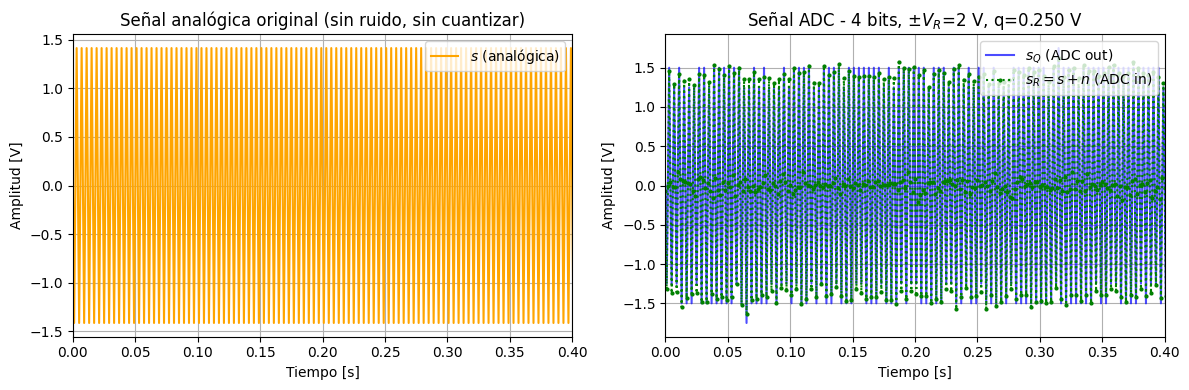

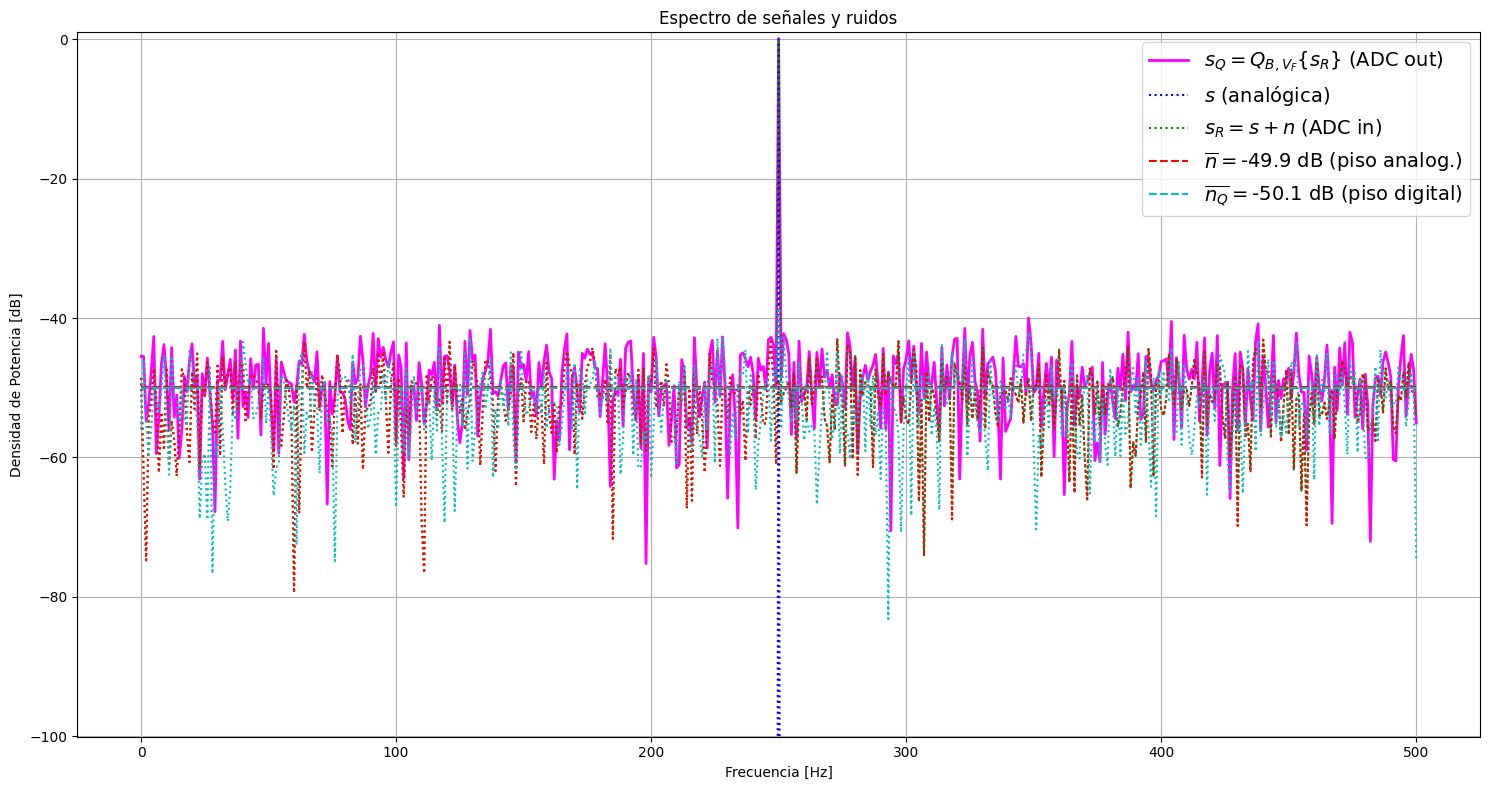

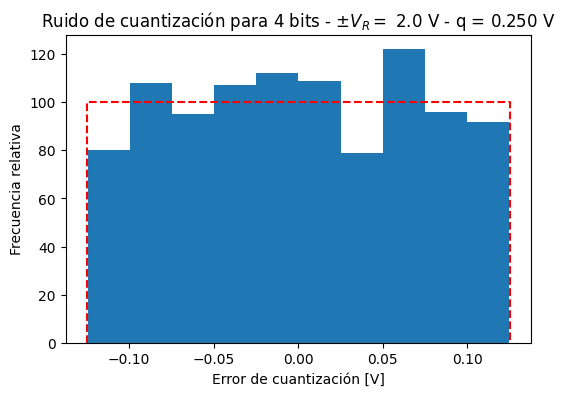

In [39]:
#Entonces propongo por ejemplo usar una frecuencia de 750Hz, ya que fs=1000Hz. 
simular_adc(B=4, kn=1, Vf=2, fs=1000, N=1000,aliasing=True)

-  En primer lugar tenemos el muestreo de la señal analógica, donde puede apreciarse el efecto de **aliasing**. Luego puede visualizarse como este fenómeno distorsiona por completo la señal de entrada y salida del ADC.
-  En cuanto al gráfico espectral, puede verse como el efecto de aliasing modifica la frecuencia central, donde aquí el pico de la señal se encuentra reflejado a 250Hz por consecuencia de este fenómeno. Lo mismo sucede con la señal en color magenta, manifestando que la señal también es malinterpretada por el ADC debido al aliasing.
-  Por lo tanto, a pesar de que los pisos de ruido no parecen mostrar deformación, muestrear por encima de la frecuecnia de Nyquist genera un efecto de aliasing que distorsiona la información de la señal, generando un desplazamiento del resultado espectral hacia una frecuencia incorrecta; lo que impide que sea cuantizada adecuadamente. 